In [7]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [19]:
dir = '/data2/DNN_masks/manual_masking_hebe/'
file = 'inference_base_event_GCS_20101212_A6_DS32fran_file__Hebe_v1_with_manual_masks.pkl'
file = 'inference_base_event_GCS_20101214_A6_DS32fran_file__Hebe_v1_with_manual_masks.pkl'

with open(dir+file, 'rb') as f:
    data = pickle.load(f)



In [23]:
data.keys()

dict_keys(['headers', 'orig_img', 'masks', 'dates', 'scores', 'labels', 'boxes', 'plate_scl', 'centerpix', 'manual_masks', 'manual_points'])

In [40]:
center_pix = data['centerpix']
len(center_pix[1][4])

2

In [41]:
mask_manual = data['manual_masks'][0][1][4]
center_pix = data['centerpix'][1][4]
plt_scale = data['plate_scl'][1][4]
orig_imagen = data['orig_img'][1][4]
mask_dnn = data['masks'][1][4]

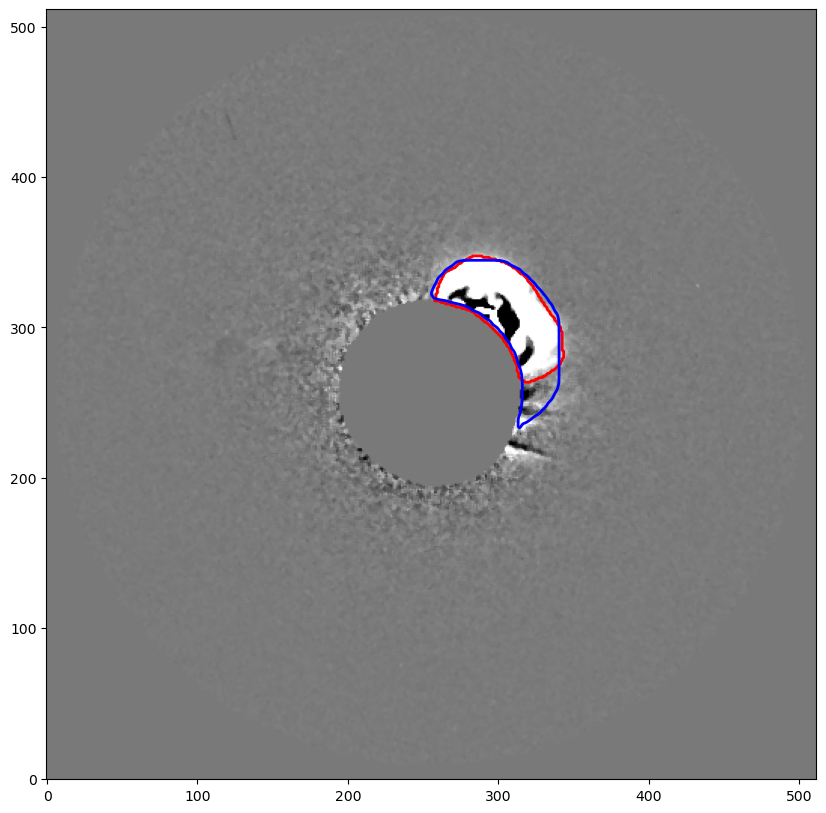

In [22]:
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot()
ax1.imshow(orig_imagen, vmin=0, vmax=1, cmap='gray', origin='lower')
ax1.contour(mask_manual, levels=[0.5], colors='red', linewidths=2)
ax1.contour(mask_dnn[1], levels=[0.5], colors='blue', linewidths=2)
plt.show()

In [24]:
def fun_area_score(mask):
    '''
    Similar to rec2pol, but returns the area of the mask related to the total images size.
    '''
    mask_threshold = 0.54
    area_score=0.
    nans = np.full(mask.shape, np.nan)
    #creates an array with zero value inside the mask and Nan value outside             
    masked = nans.copy()
    masked[:, :][mask > mask_threshold] = 0
    #calculates geometric center of the image
    height, width = masked.shape
    #calculates the amount of pixels corresponding to the mask
    for x in range(width):
        for y in range(height):
            value=masked[x,y]
            if not np.isnan(value):
                area_score = area_score + 1.
    area_score = area_score/(height*width)
    return area_score

In [25]:
def calculate_metrics(mask1, mask2):
    """
    Calculates precision, recall, dice coefficient, and intersection over union (IoU) 
    between two binary masks.
    Args:
        mask1: The first binary mask (numpy array).
        mask2: The second binary mask (numpy array). Ground truth mask.
    """
    # Flatten the masks for efficient calculations
    mask1_flat = mask1#.flatten()
    mask2_flat = mask2#.flatten()
    if len(mask1_flat) != len(mask2_flat):
        breakpoint()
    # Calculate true positives (TP), true negatives (TN), false positives (FP), and false negatives (FN)
    TP = np.sum(np.logical_and(mask1_flat, mask2_flat))
    FP = np.sum(np.logical_and(mask1_flat, np.logical_not(mask2_flat)))
    FN = np.sum(np.logical_and(np.logical_not(mask1_flat), mask2_flat))
    TN = np.sum(np.logical_and(np.logical_not(mask1_flat), np.logical_not(mask2_flat)))
    # Calculate precision, recall, dice coefficient, and IoU
    precision = TP / (TP + FP) if TP + FP > 0 else 0
    recall = TP / (TP + FN) if TP + FN > 0 else 0
    dice = (2 * TP) / (2 * TP + FP + FN) if 2 * TP + FP + FN > 0 else 0
    iou = TP / (TP + FP + FN) if TP + FP + FN > 0 else 0
    return precision, recall, dice, iou

In [26]:
def NSD_differecnce(array1,array2):
    """
    Normalized Symmetric Difference (NSD) between two arrays.
    Union - intersection / target
    """
    intersection = np.logical_and(array1, array2)
    union = np.logical_or(array1, array2)
    target = np.sum(array2)
    return (np.sum(union) - np.sum(intersection)) / target if target > 0 else 0

In [27]:
def rec2pol(mask, center=None):
    '''
    Converts the x,y mask to polar coordinates
    Only pixels above the mask_threshold are considered
    TODO: Consider arbitrary image center, usefull in case of Cor-2B images.
    NO FUNCIONA BIEN EN EL CASO DE COR2B y en relacion al plot2. CHEQUEAR
    '''
    mask_threshold = 0.54
    nans = np.full(mask.shape, np.nan)
    pol_mask=[]
    #creates an array with zero value inside the mask and Nan value outside             
    masked = nans.copy()
    #breakpoint()
    masked[:, :][mask > mask_threshold] = 0   
    #calculates geometric center of the image
    height, width = masked.shape
    if center is None:
        #case center is not defined. Calculates geometric center of the image
        center_x = width / 2
        center_y = height / 2
    else:
        #case center is defined as input. 
        center_x = center[0]
        #since occ_center is given using images coordinates, we need to invert the y axis.
        center_y = height-center[1]
        #center_y = center[1]
    #calculates distance to the point and the angle for the positive y axis
    for x in range(width):
        for y in range(height):
            value=masked[x,y]
            if not np.isnan(value):
                x_dist = (x-center_x)
                y_dist = (y-center_y)
                distance= np.sqrt(x_dist**2 + y_dist**2)
                #Si y es vertical y x es horizontal, entonces angle positivo calculado con respecto a y positivo, en forma antihoraria.
                angle = np.arctan2(x_dist,y_dist)
                if angle<0:
                    angle+=2*np.pi
                pol_mask.append([distance,angle])
    return pol_mask



In [42]:
def get_mask_props(masks, scores=None, plate_scl=1,centerpix=None, percentiles=[5,95]):
    """
    Calculate properties of masks.
    """
    scr_threshold = 0.1
    if scores != None:
        scores_out = float(scores)
    if scores == None:
        scores_out = -1
    prop_list=[]
    #breakpoint()
    #box_center = np.array([boxes[0]+(boxes[2]-boxes[0])/2, boxes[1]+(boxes[3]-boxes[1])/2])
    #if centerpix is not None:
    #    distance_to_box_center = np.sqrt((centerpix[0]/2-box_center[0])**2 + (centerpix[1]/2-box_center[1])**2)
    #else:
    #    distance_to_box_center = np.sqrt((masks.shape[0]/2-box_center[0])**2 + (masks.shape[1]/2-box_center[1])**2)
    if centerpix is None:
        centerpix = [masks.shape[0]/2,masks.shape[1]/2]
    #breakpoint()
    pol_mask=rec2pol(masks,center=centerpix)
    if (pol_mask is not None):            
            #takes the min and max angles and calculates cpa and wide angles
        angles = [s[1] for s in pol_mask]
        if len(angles)>0:
                # checks for the case where the cpa is close to 0 or 2pi
            if np.max(angles)-np.min(angles) >= 0.9*2*np.pi:
                angles = [s-2*np.pi if s>np.pi else s for s in angles]
            aw_min = np.percentile(angles, percentiles[0])
            aw_max = np.percentile(angles, percentiles[1])

                #calculate angular width
                #cut list of values (angles) between two values, aw_min and aw_max
            angles_between_percentiles = [s for s in angles if s >= aw_min and s <= aw_max]
            cpa_ang= np.median(angles_between_percentiles)
            if cpa_ang < 0:
                cpa_ang += 2*np.pi
            wide_ang=np.abs(aw_max-aw_min)
                #calculates the distance to the apex
            distance = [s[0] for s in pol_mask]
            distance_abs= max(distance, key=abs)
            idx_dist = distance.index(distance_abs)

                #angle corresponding to the apex_dist position
            angulos = [s[1] for s in pol_mask]
            apex_angl = angulos[idx_dist] 
            apex_dist = distance[idx_dist] * plate_scl
                #caclulates the area of the mask in % of the total image area
            area_score = fun_area_score(masks)
                #calculate apex distances as a percentil 98, and the corresponding angles
            apex_dist_percentile = np.percentile(distance, 98) 
            apex_dist_per = [d * plate_scl for d,a in zip(distance,angulos) if d >= apex_dist_percentile-0.5 and d<=apex_dist_percentile+0.5]
            apex_angl_per = [a for d,a in zip(distance,angulos) if d >= apex_dist_percentile-0.5 and d<=apex_dist_percentile+0.5]
    prop_list.append([scores_out,cpa_ang, wide_ang, apex_dist, apex_angl, aw_min, aw_max, area_score,np.median(apex_dist_per),np.median(apex_angl_per)])
    if len(masks) == 0:
        prop_list.append([np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, [np.nan], [np.nan]])
    return prop_list


In [ ]:

mask_props_dnn = get_mask_props(mask_manual,scores=scores[imax],plate_scl=plt_scale,centerpix=center_pix)

In [ ]:
wcpa_dnn[index_header]      = mask_props_dnn[0][1]
aw_min_dnn[index_header]    = mask_props_dnn[0][5]
aw_max_dnn[index_header]    = mask_props_dnn[0][6]
area_dnn[index_header]      = mask_props_dnn[0][7]
apex_dnn[index_header]      = mask_props_dnn[0][8]
apex_angl_dnn[index_header] = mask_props_dnn[0][9]